## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

## A note on structure  

The structure of this notebook is a little backwards. What we see at the top in the `Code` section is a collection of "final draft" functions used to drive the project algorithm. 

Below this, in the `EDA` section, we see some of the analysis and decision process that led to the development of these functions.

It should also be stated: the `EDA` section should be viewed as "lightly structured chaos". While this code and analysis commented with some semblance of narrative, not all of these thoughts are complete. There should be enough to follow, but those looking of a more complete/linear view of what has been done here should stick with the `Code` section.


### Code

In [2]:
import glob

import numpy as np
import scipy as sp
import scipy.io

# Adding additional tools here
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import pickle


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estim0tes = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


############## Novel helper functions from here ############## 


def lowpass_acc_filter(signal, fs=125):
    """ Lowpass filter. A simple wrapper for the scipy Butterworth filter, specifically 
    intended for accelerometer signal
    
    Args
        signal: (np.array) input signal
        fs: (int) the sampling rate 
    
    Returns:
        np.array bandpass filered array of the input signal
    """
    b, a = sp.signal.butter(3, 12, btype='lowpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def featurize_acc_channels(accx, accy, accz, fs=125, frequency_range=(40/60, 240/60)):
    """A partial featurization of the accelerometer signal.
    Attribution: function is adapted from previous lessons
    
    Args:
        accx: (np.array) x-channel of the accelerometer
        accy: (np.array) y-channel of the accelerometer
        accz: (np.array) z-channel of the accelerometer
        fs: (number) the sampling rate 
        frequency_range: (tuple) upper and lower frequency filtering limits, respectivly
        
    Returns:
        n-tuple of accelerometer features
    """
    accx = bandpass_filter(accx, frequency_range, fs)
    accy = bandpass_filter(accy, frequency_range, fs)
    accz = bandpass_filter(accz, frequency_range, fs)
    
    # Some single channel means
    mn_x = np.mean(accx)
    mn_y = np.mean(accy)
    mn_z = np.mean(accz)
    
    # The standard deviation of the x-channel
    std_x = np.std(accx)

    # The 5th percentile of the x-channel
    p5_x = np.percentile(accx, 5)

    # The pearson correlation coefficient between the x and y channels
    corr_xy = sp.stats.pearsonr(accx, accy)[0]

    # The total AC energy of the x-axis
    energy_x = np.sum(np.square(accx - np.mean(accx)))
    
    # Take an FFT of the signal. If the signal is too short, 0-pad it so we have at least 2046 points in the FFT.
    # FIXME we're only going to work with complete windows
    fft_len = len(accx)
    
    # Create an array of frequency bins
    fft_freqs = np.fft.rfftfreq(fft_len, 1 / fs)
    
    # Take an FFT of the centered signal
    fft_x = np.fft.rfft(accx - np.mean(accx), fft_len)
    
    # The frequency with the most power between 0.25 and 12 Hz 
    # Presumably these frequency ranges are still relevant...
    low_freqs = (fft_freqs >= 0.25) & (fft_freqs <= 12)    
    
    # Magnitude of Fourier transform within this window to find dominant frequency
    dominant_frequency_x = fft_freqs[np.argmax(np.abs(fft_x)[low_freqs])]

    # The fraction of energy between 2 and 3 Hz in the x-channel
    spectral_energy_x = np.square(np.abs(fft_x))
    energy_23_x = np.sum(spectral_energy_x[(fft_freqs >= 2) & (fft_freqs <= 3)]) / np.sum(spectral_energy_x)
    
    # For reasons that mostly have to do with familiarity, let's manage these data types with pandas
    acc_channel_df = pd.DataFrame(data={"mn_x":[mn_x],
                                        "mn_y":[mn_y],
                                        "mn_z":[mn_z],
                                        "std_x":[std_x],
                                        "p5_x":[p5_x],
                                        "corr_xy":[corr_xy],
                                        "energy_x":[energy_x],
                                        "dominant_frequency_x":[dominant_frequency_x],
                                        "energy_23_x":[energy_23_x]})
    
    return acc_channel_df


def bandpass_filter(signal, pass_band, fs=125):
    """Bandpass Filter inteded to threshold signals between  
    Attribution: this function is modified version of feature creation suggested from previous lessons
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def featurize_ppg(ppg, fs=125, lfilt_upper=12, lfilt_lower=0.25, frequency_range=(40/60, 240/60)):
    """Consolidates a series of preprocess and feature engineering functions
    designed to operate over ppg signal data.
    
    Args:
        ppg: (np.array) The input signal
        fs: (integer) The sampling rate of the ppg signal
        lfilt_upper: (float) upper frequency limit for bandpass filter 
        lfilt_lower: (float) lower frequency limit for bandpass filter
        frequency_range: (tuple) upper and lower frequency filtering limits, respectivly
        
    Returns:
        (pd.DataFrame) of aggregated, preprocessed ppg features.
    """
    # Bandpass filter, as above
    ppg = bandpass_filter(ppg, frequency_range, fs=fs)
    
     # The mean of the x-channel
    mn_ppg = np.mean(ppg)

    # The standard deviation of the x-channel
    std_ppg = np.std(ppg)

    # The 5th percentile of the x-channel
    p5_ppg = np.percentile(ppg, 5)
    
    # The total AC energy of ppg
    energy_ppg = np.sum(np.square(ppg - np.mean(ppg)))
    
    # Take an FFT of the signal. If the signal is too short, 0-pad it so we have at least 2046 points in the FFT.
    # FIXME we're only going to work with complete windows
    fft_len = len(ppg)
    
    # Create an array of frequency bins
    fft_freqs = np.fft.rfftfreq(fft_len, 1 / fs)
    
    # Take an FFT of the centered signal
    fft_ppg = np.fft.rfft(ppg - np.mean(ppg), fft_len)
    
    # Bandpass frequencies between limits specified within argument parameters
    low_freqs = (fft_freqs >= lfilt_lower) & (fft_freqs <= lfilt_upper)    
    
    # Magnitude of Fourier transform within this window to find dominant frequency
    dominant_frequency_ppg = fft_freqs[np.argmax(np.abs(fft_ppg)[low_freqs])]

    # For reasons that mostly have to do with familiarity, let's manage these data types with pandas
    ppg_df = pd.DataFrame(data={"mn_ppg":[mn_ppg],
                                "std_ppg":[std_ppg],
                                "p5_ppg":[p5_ppg],
                                "energy_ppg":[energy_ppg],
                                "dominant_frequency_ppg":[dominant_frequency_ppg]})
    
    return ppg_df


def featurize_acc_magnitude(accx, accy, accz, fs=125, lfilt_upper=12, lfilt_lower=0.25, frequency_range=(40/60, 240/60)): 
    """A partial featurization of the accelerometer signal.
    Attribution: this function is modified version of feature creation suggested from previous lessons
    
    Args:
        accx: (np.array) x-channel of the accelerometer.
        accy: (np.array) y-channel of the accelerometer.
        accz: (np.array) z-channel of the accelerometer.
        fs: (number) the sampling rate of the accelerometer
        lfilt_upper: (float) upper frequency limit for low frequncy feature
        lfilt_lower: (float) lower frequency limit for low frequency feature
        frequency_range: (tuple) upper and lower frequency filtering limits, respectivly
        
    Returns:
        (pd.DataFrame) of aggregated, preprocessed accelerometer features
    """
    accx = bandpass_filter(accx, frequency_range, fs)
    accy = bandpass_filter(accy, frequency_range, fs)
    accz = bandpass_filter(accz, frequency_range, fs)
    
    # Compute magnitude across channels
    acc_magnitude = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
    
    # The mean of the acc magnitude
    mn_acc_magnitude = np.mean(acc_magnitude)
    
    # The standard deviation of the x-channel
    std_acc_magnitude = np.std(acc_magnitude)

    # The 5th percentile of the x-channel
    p5_acc_magnitude = np.percentile(acc_magnitude, 5)

    # The total AC energy of the x-axis
    energy_acc_magnitude = np.sum(np.square(acc_magnitude - np.mean(acc_magnitude)))
    
    # Take an FFT of the signal. If the signal is too short, 0-pad it so we have at least 2046 points in the FFT.
    # FIXME we're only going to work with complete windows
    fft_len = len(acc_magnitude)
    
    # Create an array of frequency bins
    fft_freqs = np.fft.rfftfreq(fft_len, 1 / fs)
    
    # Take an FFT of the centered signal
    fft_acc_magnitude = np.fft.rfft(acc_magnitude - np.mean(acc_magnitude), fft_len)
    
    # Bandpass frequencies between limits specified within argument parameters 
    low_freqs = (fft_freqs >= lfilt_lower) & (fft_freqs <= lfilt_upper)    
    
    # Magnitude of Fourier transform within this window to find dominant frequency
    dominant_frequency_mag = fft_freqs[np.argmax(np.abs(fft_acc_magnitude)[low_freqs])]

    # The fraction of energy between 2 and 3 Hz in the x-channel
    spectral_energy_x = np.square(np.abs(fft_acc_magnitude))
    energy_23_mag = np.sum(spectral_energy_x[(fft_freqs >= 2) & (fft_freqs <= 3)]) / np.sum(spectral_energy_x)
    
    # For reasons that mostly have to do with familiarity, let's manage these data types with pandas 
    acc_mag_df = pd.DataFrame(data={"mn_acc_magnitude":[mn_acc_magnitude],
                                    "std_acc_magnitude":[std_acc_magnitude],
                                    "p5_acc_magnitude":[p5_acc_magnitude],
                                    "energy_acc_magnitude":[energy_acc_magnitude],
                                    "dominant_frequency_mag":[dominant_frequency_mag], 
                                    "energy_23_mag":[mn_acc_magnitude]})
    
    return acc_mag_df


def featurize(ppg, accx, accy, accz, ref_file, subject_code=0):
    """A wrapper function to run both preprocessing and 'featurization' functions
    on both PPG and accelerometer data frames, as well as adding a target column.
    
    Args:
        ppg: (np.array) The input signal
        accx: (np.array) x-channel of the accelerometer.
        accy: (np.array) y-channel of the accelerometer.
        accz: (np.array) z-channel of the accelerometer.
        Subject_code (integer): an arbitrary unique value used to distinguish subject files
        
    Returns:
        (pd.DataFrame) of collection of aggregated, preprocessed ppg and accelerometer features
    
    """    
    # Add time to the training set
    time = [x * (1/125) for x in range(1, len(ppg) +1)]
    
    # Window parameters
    start_window_index = 0
    end_window_index = 1000
    data_window_stride = 250

    ref_counter = 0
    training_set = pd.DataFrame()

    while end_window_index < len(ppg):

        # Window features
        windowed_ppg = ppg[start_window_index: end_window_index]
        windowed_accx = accx[start_window_index: end_window_index]
        windowed_accy = accy[start_window_index: end_window_index]
        windowed_accz = accz[start_window_index: end_window_index]
        windowed_time = time[start_window_index: end_window_index]

        # Run feature extraction functions
        ppg_df = featurize_ppg(windowed_ppg, 125)
        acc_df = featurize_acc_channels(windowed_accx, windowed_accy, windowed_accz, 125)
        acc_mag_df = featurize_acc_magnitude(windowed_accx, windowed_accy, windowed_accz, 125)
        
        # Append
        temp_concat = pd.concat([ppg_df, acc_df, acc_mag_df], axis=1)
        temp_concat["time"] = min(windowed_time)
        
        # Add to the full data frame
        training_set = training_set.append(temp_concat)

        # Iterate the counters
        ref_counter += 1
        start_window_index += data_window_stride
        end_window_index += data_window_stride

    # Add the label
    training_set["label"] = ref_file[:len(training_set)]
    
    # Let's do the same with the subject code
    training_set["subject"] = subject_code * len(training_set)
    
    return training_set    


def create_training_set(data_fls, ref_fls):
    """Run the 'featureize' function of all available data files to create a training set
    
    Args:
        data_fls: (list) a list of paths to for Troika 'DATA' files
        ref_fls: (list) a list of paths to for Troika 'REF' files
        
    Returns:
        (pd.DataFrame) of collection of aggregated, preprocessed ppg and accelerometer features extracted 
        from all specified input files
    """
    # Data frame to hold featurized training data
    training_set = pd.DataFrame()

    # Loop through all the files and create a training set
    for x in range(0, len(data_fls)):

        # Pull out something we can use as the subject code
        subject_code = data_fls[x].split("/")[-1].split(".")[0]

        # Load data file
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[x])

        # Load the ref file
        temp_ref = sp.io.loadmat(ref_fls[x])["BPM0"]

        # Featurize!
        training_set = pd.concat([training_set,
                                  featurize(ppg, accx, accy, accz, temp_ref, subject_code)])
        
        
        return training_set    
    

def create_model_object(data_fls, ref_fls):
    """Creates a training set from specified DATA and REF Troika files, trains
    a random forest model to predict HR, and returns this model.
    
     Args:
        data_fls: (list) a list of paths to for Troika 'DATA' files
        ref_fls: (list) a list of paths to for Troika 'REF' files
        
    Returns:
        (sklearn) a random forest regressor model object    
    """
    # Create a training set
    training_set = create_training_set(data_fls, ref_fls)
    
    # Train the model
    rfr = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=100)
    rfr.fit(training_set.drop(columns=["label", "subject"]), training_set["label"])

    importance = sorted(list(zip(rfr.feature_importances_,
                                 training_set.drop(columns=["label", "subject"]).columns)),
                                 reverse=True)[:-18]

    select_features = [x[1] for x in importance]
    
    gbr = GradientBoostingRegressor(random_state=42, n_estimators=10)
    gbr.fit(training_set[select_features], training_set["label"])
    
    return gbr, select_features

In [3]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """Trains a pulse rate algorithm on prespecified Troika DATA and REF files, 
    accepts novel data files specifiying PPG and accelerometer signals that adhere to the same architecture 
    as Troika files, and returns a pulse rate prediction.
    
     Args:
        data_fls: (list) a list of paths to for Troika 'DATA' files
        ref_fls: (list) a list of paths to for Troika 'REF' files
        
    Returns:
        errors: (np.array) absolute error of prediction compared to ground truth (specified in ref_fl)
        confidence: (np.array): computed confidence of prediction
    
    """
    # Load training data and build base model
    data_fls, ref_fls = LoadTroikaDataset()
    training_set = create_training_set(data_fls, ref_fls)
    predictor_algo, select_features = create_model_object(data_fls, ref_fls)
    
    # Extract features from data file using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Compute pulse rate estimates and estimation confidence.
    
    # Load the ref file
    ref_file = sp.io.loadmat(ref_fl)["BPM0"]
    
    # Featurize to reshape data for prediction
    prediction_frame = featurize(ppg, accx, accy, accz, ref_file, subject_code=0)
    
    # Predict
    prediction_frame["y_hat"] = predictor_algo.predict(prediction_frame[select_features])
    #prediction_frame["y_hat"] = prediction_frame["y_hat"].rolling(5, min_periods=1).mean()
    
    # Compute the error of each prediction
    prediction_frame["mae"] = (prediction_frame["label"] - prediction_frame["y_hat"]).abs()
    
    # Compute the confidence of each prediction. Here, we're going to keep it simple:
    prediction_frame["confidence"] = prediction_frame["energy_ppg"] / (prediction_frame["energy_ppg"] + prediction_frame["energy_acc_magnitude"])
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.array(prediction_frame["mae"]), np.array(prediction_frame["confidence"])
    
    return errors, confidence

## EDA
As mentioned above, all forms of EDA that are inteded for reusable in the form of preprocessing and prediction will be consolidated as functions for later use. The process of _arriving_ at these functions will be somewhat of a sprawling (albeit documented) string of cells. 

**Start by familiarizing with the files, and how to work with them**

In [4]:
# First, a quick review of the trainin data directory
!ls -ltr ./datasets/troika/training_data/

total 7644
-rw-r--r-- 1 root root   1163 Feb  3  2020 REF_12_TYPE02.mat
-rw-r--r-- 1 root root   1060 Feb  3  2020 REF_11_TYPE02.mat
-rw-r--r-- 1 root root   1082 Feb  3  2020 REF_10_TYPE02.mat
-rw-r--r-- 1 root root   1196 Feb  3  2020 REF_08_TYPE02.mat
-rw-r--r-- 1 root root   1190 Feb  3  2020 REF_07_TYPE02.mat
-rw-r--r-- 1 root root   1100 Feb  3  2020 REF_06_TYPE02.mat
-rw-r--r-- 1 root root   1118 Feb  3  2020 REF_05_TYPE02.mat
-rw-r--r-- 1 root root   1152 Feb  3  2020 REF_04_TYPE02.mat
-rw-r--r-- 1 root root    790 Feb  3  2020 REF_04_TYPE01.mat
-rw-r--r-- 1 root root   1132 Feb  3  2020 REF_03_TYPE02.mat
-rw-r--r-- 1 root root   1238 Feb  3  2020 REF_02_TYPE02.mat
-rw-r--r-- 1 root root   1188 Feb  3  2020 REF_01_TYPE01.mat
-rw-r--r-- 1 root root  62394 Feb  3  2020 Readme.pdf
-rw-r--r-- 1 root root 668021 Feb  3  2020 DATA_12_TYPE02.mat
-rw-r--r-- 1 root root 668737 Feb  3  2020 DATA_11_TYPE02.mat
-rw-r--r-- 1 root root 683027 Feb  3  2020 DATA_10_TYPE02.mat
-rw-r--r-- 1 root

As previously reported, we have a collection of `.mat` files titled "DATA", and "REF".

In [5]:
# Load the data using provided functions
data_fls, ref_fls = LoadTroikaDataset()

# Note that the functions include some helpful examples for usage. 
# Here, we're just going to replicate the output of that usage
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

For starters, we know that our `LoadTroikaDataFile` will help make our "DATA" files accessible. Let's start here: what do these files look like?

In [6]:
# How _consistent_ is the shape of these files. Let's select one variable and take a
# a closer look
for x in data_fls:
    ppg, accx, accy, accz = LoadTroikaDataFile(x)
    
    print(x.split("/")[-1], ppg.shape, accx.shape, accy.shape, accz.shape)

DATA_01_TYPE01.mat (37937,) (37937,) (37937,) (37937,)
DATA_02_TYPE02.mat (37850,) (37850,) (37850,) (37850,)
DATA_03_TYPE02.mat (35989,) (35989,) (35989,) (35989,)
DATA_04_TYPE01.mat (27576,) (27576,) (27576,) (27576,)
DATA_04_TYPE02.mat (37250,) (37250,) (37250,) (37250,)
DATA_05_TYPE02.mat (37328,) (37328,) (37328,) (37328,)
DATA_06_TYPE02.mat (38373,) (38373,) (38373,) (38373,)
DATA_07_TYPE02.mat (36650,) (36650,) (36650,) (36650,)
DATA_08_TYPE02.mat (40803,) (40803,) (40803,) (40803,)
DATA_10_TYPE02.mat (38042,) (38042,) (38042,) (38042,)
DATA_11_TYPE02.mat (36500,) (36500,) (36500,) (36500,)
DATA_12_TYPE02.mat (37316,) (37316,) (37316,) (37316,)


In terms of file length, signal columns _within_ each file are consistent; however, signal length _across_ files appears to be somewhat variable. 

OK, noted. 

Now, what about our reference files? Based on my current working understanding, we should address this data like our labels. Put another way, and providing I'm not mistaken, this should be a more direct measure of our target: heart rate.

Do we need a similar function to access these files? What is the architecture of these files?

So, these files are wacky, but we can learn what we need from the source documentation. It would appear that the HR information we want is accessible via the `BPM0` key.  

Let's look.

In [7]:
# Similar code used for loading DATA files. 
example_ref = sp.io.loadmat(ref_fls[0])

# If this thing behaves like a dictionary then we should be able to... 
example_ref.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BPM0'])

In [8]:
# OK, now pull the first 10 values accessible via the `BPM0` key...
example_ref["BPM0"][:10]

array([[ 74.33920705],
       [ 76.35746606],
       [ 77.14285714],
       [ 74.66814159],
       [ 72.58064516],
       [ 71.68458781],
       [ 72.89416847],
       [ 73.44940152],
       [ 75.33482143],
       [ 76.8442623 ]])

So, it would appear that the length of these `REF` do _not_ line up ideally with their corresponding `DATA` files. Once again to the source material, I think this has to do with the fact that what we're looking at in the `REF` file is not raw -- it's the result of partially overlapping 8 and 6 second sliding windows.  

More detail on that in the doc, but we're going to go ahead with the working understanding that all is as it should be. 

What we're looking at in this file is the HR for each window... So this means that we need a way to divide 
each of the other samples into the _same_ chunks.

In [10]:
example_ref["BPM0"].shape[0]

148

                0
count  148.000000
mean   133.405702
std     30.287462
min     69.587629
25%    111.354990
50%    150.158061
75%    154.998739
max    165.615142


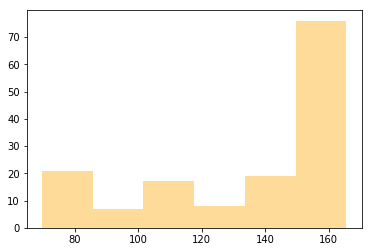

In [11]:
# We've been told to filter the ppg signal... Does the target also adhere? 
print(pd.DataFrame(example_ref["BPM0"]).describe())
sns.distplot(example_ref["BPM0"], color="orange", kde=False);

**Windowing the `DATA` file to correspond with target information in the `REF` file**

In [12]:
# Let's do some quick math. 

# If each window is 8 seconds. This means that, within our DATA file, the number of 
# data points we have per window is: 
data_window_size = int(8 / (1/125))
data_window_size

1000

In [13]:
# But what about the strides of this window? 

# If I'm understanding this correctly, each window will advance 2 seconds of data (and overlap by 6)

# In data, this amounts to:
data_window_stride = int(2 / (1/125))
data_window_stride

250

In [14]:
# Rough code for how to split these samples into the desired window size
windows = []

start_window_index = 0
end_window_index = data_window_size

while end_window_index < len(ppg):
    
    temp_window = ppg[start_window_index: end_window_index]
    
    windows.append(temp_window)
    
    start_window_index += data_window_stride
    end_window_index += data_window_stride

In [15]:
def window_the_data(input_signal):
    """
    
    """
    windows = []
    
    # Counters to track window index 
    start_window_index = 0
    end_window_index = data_window_size

    while end_window_index < len(input_signal):

        temp_window = ppg[start_window_index: end_window_index]

        windows.append(temp_window)

        start_window_index += data_window_stride
        end_window_index += data_window_stride
        
    return windows

In [16]:
# Let's confirm that this makes sense. Confirm the length 
print("Total number of windows: ", len(windows))
print("Samples per window: ", len(windows[1]))

Total number of windows:  146
Samples per window:  1000


**Plot some signals and transformations**
Here, we're trying to get a better sense of what the data signals look like, and the effect of different preprocessing approaches.

In [17]:
# Alright.... At this point, I think we should do some plotting. But then, we're presented with a decision:

# do we develop some kind of empirical method of pulling signial from noise, or do we want to learn it?

# Look at a few windows, the corresponding HR, and make a determination.

# More notes on method: part of how we're going to distinguish signal from noise is to pull in the accel
# stuff, perhaps we need to start with this... also, we probably need to plot some of this, too. n

In [18]:
# Wait... after running a quick sns.lineplot function -- how old are the packages in this environment?
!conda list | grep sea

seaborn                   0.8.1                    py36_0    conda-forge


In [19]:
# So, this is the start of a massive mistake, but I'd really prefer to use some
# updated tools... 

#!conda update seaborn 


# Nope. Taking too long. Kill it. We're going full matplotlib.

In [20]:
def data_time_dimension(signal, fs=125):
    
    return [x * (1/fs) for x in range(1, len(signal) +1)]

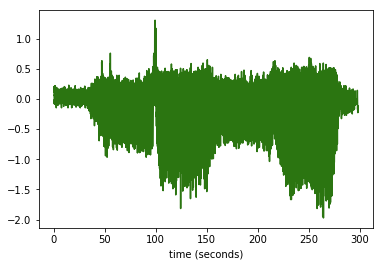

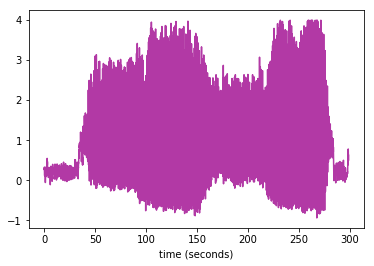

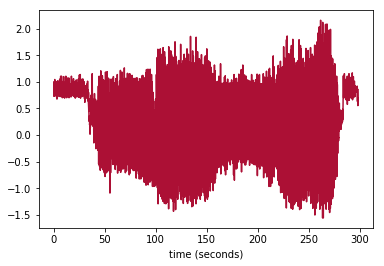

In [21]:
for plot_it in [accx, accy, accz]:
    plt.plot(data_time_dimension(plot_it), plot_it, c=np.random.rand(3,))
    plt.xlabel("time (seconds)")
    
    plt.show()

In [23]:
# Now, we're going to think about the features we might want to create to make use of all this... I think that 
# we can make notes of several features that were present within 

The first thing I'd like to address before plotting things up, in earnest, is _time_. What can we infer about the time of these samples?

---- older notes to address
For starter, accepting that the `DATA` and `REF` files are different lengths, they should still 

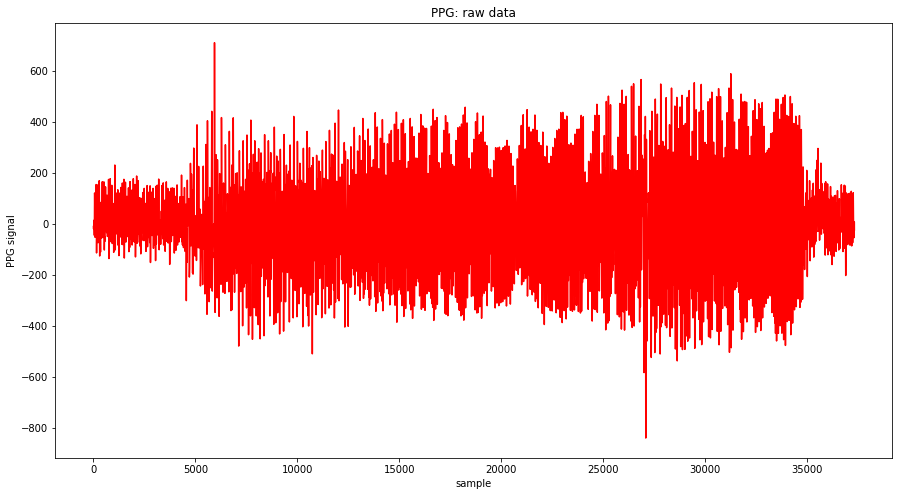

In [24]:
plt.figure(figsize=(15, 8))
plt.plot(ppg, color="red")

plt.xlabel("sample")
plt.ylabel("PPG signal")
plt.title("PPG: raw data");

Alright, well, first impressions: this is a bit of a mess. Before we go about the process of looking for peaks, I suspect we need to clean things up. 

For starters, we've been encouraaged to consider a bandpass filter. Let's start there. 

Note also that there was a range that was specified... but this range was in bmp. we need to convert this.

In [25]:
# From documentation, know the sample rate is 125 Hz
fs = 125

# TODO note that this is direct from Exercise 4 spectrograms
def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

In [26]:
# Note the cutoffs converted from BPM to Hz (BPS, as it were)

#  I don't see a reason why I can't do this to the 
# whole array... (as opposed to windows)
filtered_sig = BandpassFilter(ppg, (40/60, 80/60), fs=fs)

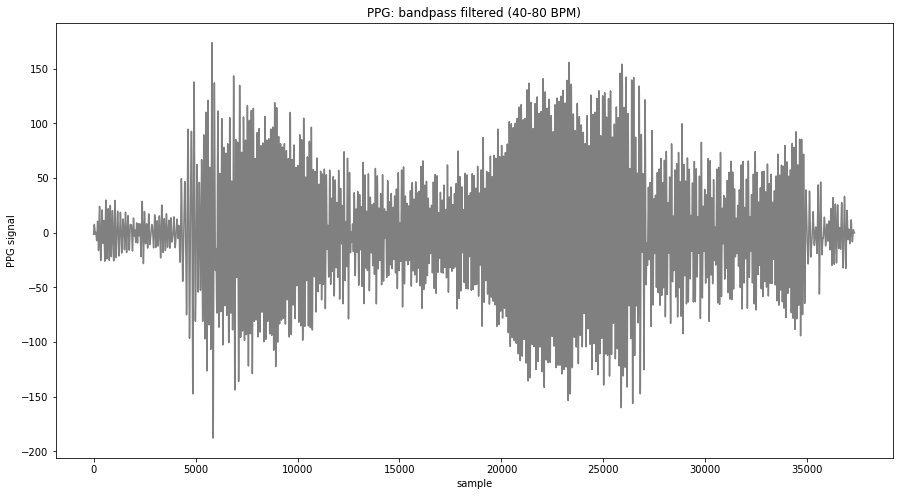

In [27]:
plt.figure(figsize=(15, 8))
plt.plot(filtered_sig, color="grey")

plt.xlabel("sample")
plt.ylabel("PPG signal")
plt.title("PPG: bandpass filtered (40-80 BPM)");

Now, based on what we know, I think the strategy moving forward is to establish if we can establish clear rules 
within the frequency domain to distinguish heart rate signal from accelerometer signal.

There could be a learning component to this... But I'd really rather just stick with rules-based signal processing if we can get away with it.

So, next. What does our bandpass-filtered signal now look like, in the frequency domain?

(0.5, 2)

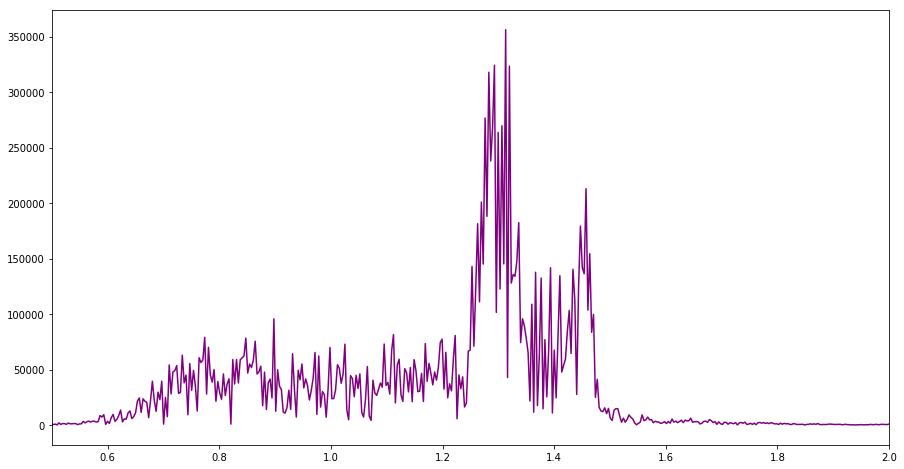

In [28]:
# We know that things are going to ramp up. As a consequence, we
# need to apply a windowing method.

# For now, I'm curious, what does the whole file look like?
freqs = np.fft.rfftfreq(len(filtered_sig), 1/fs)
coefs = np.abs(np.fft.rfft(filtered_sig))

plt.figure(figsize=(15, 8))
plt.plot(freqs, coefs, color="purple")
plt.xlim(0.5, 2)

Now let's do it right. We know that there is a "ramping up" of exercise across these sessions: this is to say, the frequency profile of each session will change across the time domain. In these cases, we've been encouraged to consider a short-time Fourier transform method to window our samples.  

Let's review the implementation of this. 

In [29]:
# Adapting some starter code from Lesson 2: plottin signals in the frequency domain

# TODO I think that the window size and stride are still in question here
window_len = 8
window_shift = 6

freq = np.fft.rfftfreq(window_len, 1/fs)
stft = []

for i in range(0, len(filtered_sig) - window_len, window_shift):
    seg = filtered_sig[i: i + window_len]
    fft = np.fft.rfft(seg)
    stft.append(np.abs(fft))

stft = np.array(stft).T

In [30]:
# Now, what do we _do_ with this? Well, I think that we want to sample over these windows...

# Consider pulling the dominant frequency from each window.
stft.shape

(5, 6218)

In [31]:
# How long are the sessions supposed to be? 5 minutes?

# I thought about this for a long enough to do it the dumb way
time_dim = [0]
running_time_counter = 0

for x in range(0, len(filtered_sig)):
    running_time_counter += 1/fs
    
    time_dim.append(running_time_counter)

# What are we looking at here?
max(time_dim) / 60

# So, I'm going to call this close enough

4.975466666667164

In [32]:
# This is a better way to compute time
faster_time = [x * (1/fs) for x in range(1, len(filtered_sig))]

max(faster_time) / 60

4.975333333333333

In [33]:
# Also, let's go ahead and create a function for this; we're likely to use again. 
def return_time_dimension(signal):
    """Function that takes signal array sampled at specified frequency
    and returns a list 
    
    signal: array
    
    returns: list
    """
    time_dim = []
    running_time_counter = 0

    for x in range(1, len(signal)):
        running_time_counter += 1/fs

        time_dim.append(running_time_counter)
    
    return time_dim

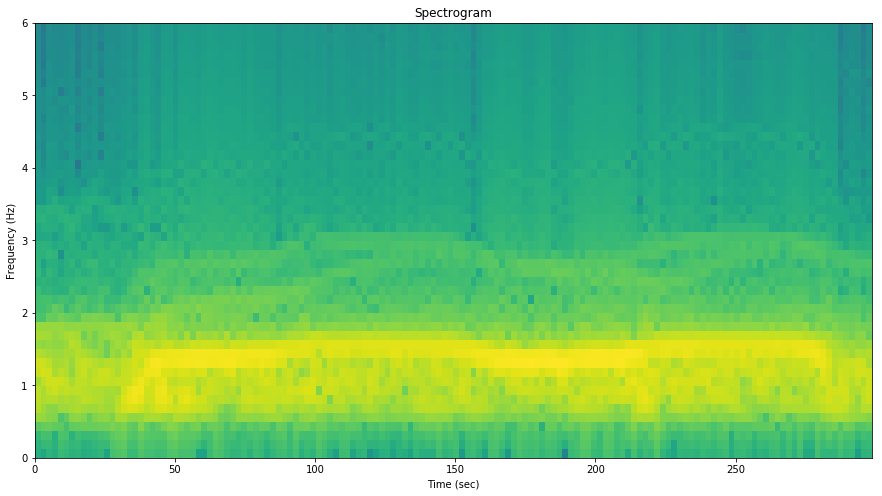

In [34]:
time = return_time_dimension(filtered_sig)

plt.figure(figsize=(15, 8))

# Some pause on the size of these windows/strides... We're compatible with the ground truth, which I suppose
# makes sense. 
plt.specgram(filtered_sig, Fs=fs, NFFT=8*fs, noverlap=6*fs, xextent=((0, time[-1])))
plt.ylim((0, 6))
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram');

All I can say about this spectrogram at this point is that we're going to care about some of these frequencies more than others. 

To make use of this, we need to pull out some of the other arguments that we can pull from

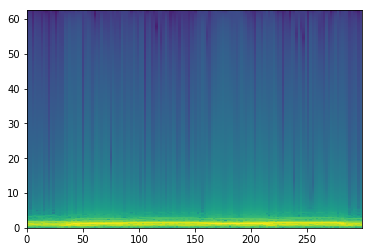

In [35]:
# Variable output taken directly from documentation...
Pxx, freqs, bins, im = plt.specgram(filtered_sig, Fs=fs, NFFT=8*fs, noverlap=6*fs, xextent=((0, time[-1])));

In [8]:
example_ref["BPM0"][:10]

array([[ 74.33920705],
       [ 76.35746606],
       [ 77.14285714],
       [ 74.66814159],
       [ 72.58064516],
       [ 71.68458781],
       [ 72.89416847],
       [ 73.44940152],
       [ 75.33482143],
       [ 76.8442623 ]])

/opt/conda/lib/python3.6/site-packages/matplotlib/mlab.py:1281: UserWarning: Only one segment is calculated since parameter NFFT (=1000) >= signal length (=148).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


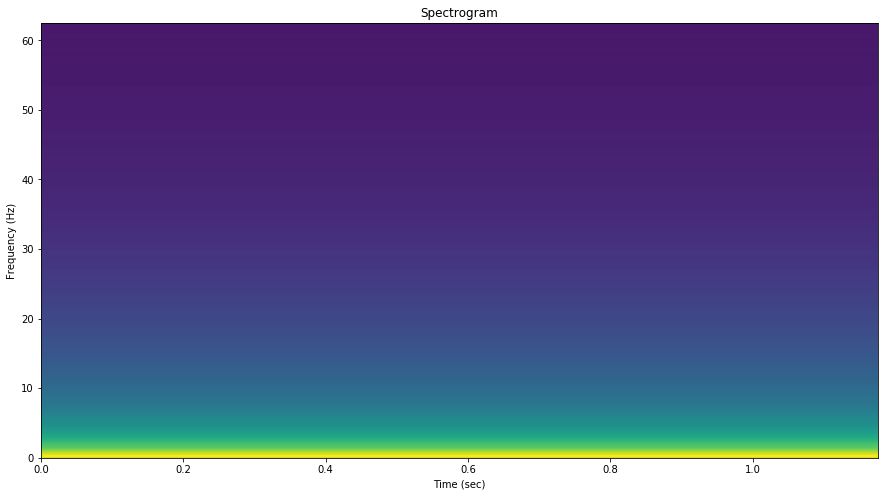

In [37]:
# Well, so I still want to look at the actual values that come out of this, but now I want to line this up 
# against what we understand of ground truth
time = return_time_dimension(example_ref["BPM0"])

plt.figure(figsize=(15, 8))

# Some pause on the size of these windows/strides... We're compatible with the ground truth, which I suppose
# makes sense. 
plt.specgram(example_ref["BPM0"], Fs=fs, NFFT=8*fs, noverlap=6*fs, xextent=((0, time[-1])))
#plt.ylim((0, 6))
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram');

In [38]:
np.argmax(Pxx, axis=0)

array([10,  9,  8,  8,  8,  8,  7,  8,  9, 10,  8,  9,  9,  8,  8,  6,  6,
        7,  7,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       11, 12, 12, 11, 12, 12, 12, 12, 12, 12, 12, 11, 11, 12, 11, 12, 12,
       12, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 10,
       10, 11, 11, 11, 11, 11, 12, 11, 11, 12, 12, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11,
       11, 10, 10,  7,  8,  7, 10,  9,  9,  7])

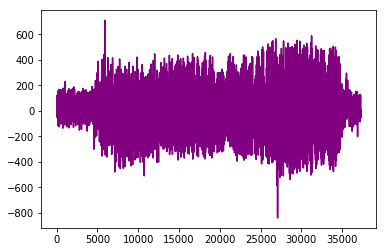

In [42]:
# TODO change the figure size... 
plt.plot(range(0, len(ppg)),
    ppg, color="purple")

At this point in the analysis, I have a good (enough) understanding of what the signal looks like, as well as the other signals (primarially "movement") that could serve to bias this signal. At this point, we should think about whether we want to move forward with some kind of deterministic model that uses explicit rules to distinguish signal from noise, of if we want to move forward with an approach that would _learn_ these rules.

**Model performance is garbage (update: but it's better now)**  
In this section, I'm going to set up some infrastructure to review-and-tweak the performance of the algorithm functions.

In [5]:
data_fls, ref_fls = LoadTroikaDataset()
training_set = create_training_set(data_fls, ref_fls)

In [6]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=100)
rfr.fit(training_set.drop(columns=["label", "subject"]), training_set["label"])

y_hat = rfr.predict(training_set.drop(columns=["label", "subject"]))

# Return mae
mean_absolute_error(training_set["label"], y_hat)

0.44861961376772841

In [7]:
importance = sorted(list(zip(rfr.feature_importances_,
                             training_set.drop(columns=["label", "subject"]).columns)),
                             reverse=True)[:-16]

select_features = [x[1] for x in importance]

gr = GradientBoostingRegressor()
gr.fit(training_set[select_features], training_set["label"])

y_hat = gr.predict(training_set[select_features])

# Return mae
mean_absolute_error(training_set["label"], y_hat)

# That might be enough to get us over threshold...

0.13387897304688343

In [21]:
# One last though: the rubric makes reference to the fact that the algorithm should 
# "run on the test subject without errors". 

# Looking at files, I don't see a _designated_ test set. 

# I'm going to assume that this statement should be interpreted as "if we run this algorithm across example cases
# I shouldn't error"
!ls datasets/troika/training_data/

DATA_01_TYPE01.mat  DATA_07_TYPE02.mat	REF_01_TYPE01.mat  REF_07_TYPE02.mat
DATA_02_TYPE02.mat  DATA_08_TYPE02.mat	REF_02_TYPE02.mat  REF_08_TYPE02.mat
DATA_03_TYPE02.mat  DATA_10_TYPE02.mat	REF_03_TYPE02.mat  REF_10_TYPE02.mat
DATA_04_TYPE01.mat  DATA_11_TYPE02.mat	REF_04_TYPE01.mat  REF_11_TYPE02.mat
DATA_04_TYPE02.mat  DATA_12_TYPE02.mat	REF_04_TYPE02.mat  REF_12_TYPE02.mat
DATA_05_TYPE02.mat  prediction_algo	REF_05_TYPE02.mat
DATA_06_TYPE02.mat  Readme.pdf		REF_06_TYPE02.mat


**Can we pickel our model for use in later exercises?**

In [ ]:
# Well, so maybe we need to save this thing
pickle.dump(rfr, open("/home/workspace/datasets/troika/training_data/prediction_algo", 'wb'))

# Confirm that we can find it
!ls -ltr /home/workspace/datasets/troika/training_data/

**Note** It would appear that we don't have the ability to pickle these model objects and access across workspaces... So we gotta train it here. Updating function accordingly.

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

**Code description**   
As mentioned above, this notebook is divided in two sections: `Code` and `EDA`. The `Code` section is a collection of "final draft" functions used to drive the project algorithm, whereas the `EDA` section contains the analysis and decision process that led to the development of these functions.

All preprocessing, training, prediction, and error functions are consolidated within the `Code` section, and driven by the `RunPulseRateAlgorithm` function. This function expects two arguments as input, `data_fl` and `ref_fl`. These arguments accept data files conforming to the structure of Troika `DATA` and `REF` files, respectivly. When run, this function will 1) train an algorithm on a specified population of data, and 2) predict on a population of data specified as input arguments, and 3) return error and confidence metrics in the form of array output.

Reviewing module dependencies: `glob` is used for collating file paths, `scipy` is used for signal processing and preprocessing operations, `numpy` is used for statistical operations on array and tabular data, `pandas` is used for statistical operations on tabular data, and `scikit-learn` was used for model building. Specific version numbers for required dependencies are as follows:

```
scikit-learn              0.19.1
glob                      3.9.29
scipy                     1.2.1
numpy                     1.12.1
pandas                    0.23.3
```

All functions have be written with functions that accept alternative values; in the current use case, the provided defaults are recommended. 


**Data description**  
The algorithm was trained on 12 files from the Troika dataset. Signal from the provided PPG sensors and accelerometers were bandpass filered and preprocessed to extract frequency and aggregated summary statistics that were hypothesized to explain variance within the target variable (heart rate)

As discussed in more detail within the `Algorithm` section, the decision was made to _learn_ patterns within signal (and noise) that would be useful to making predictions on the target. This decision comes in contrast to a more "deterministic" approach to signal processing, whereby these patterns are identified and leveraged in a more explicit/manual way. This architecture was selected on the basis that a more diverse range of inputs could, in theory, be more robust to noise observed within input signal data (see `EDA` section for more detail).

This decision, however, comes at the expense of knowing that the training set is comparativly small, and as a result, the danger that true patterns of signal and noise might not be sufficiently common to learn and subsequently generalize to test cases. As noted later in this report, passing performance _was_ achieved. 


**Algorithm description**  
A random forest algorithm was trainined on a series of aggregated features extracted from PPG and accelerometer signal (taken from `DATA` files), and optimized to predict a target heart rate (taken from `REF` files). The "window" across data was aggregated (and within which heart rate predictions were made) was set to mirror that used within the `REF` files specified by authors in the Troika dataset. 

It should be stressed, here, addressing the statements within the rubric:

`Reference values and estimates are appropriately paired (eg. using nearest neighbor or interpolation technique).`

and  

`Mean absolute error is computed correctly.`

"Interpolation" was not strictly necessary, as the "windowed" approach to aggregating features within signal input (PPG and Accel) were sufficient to match the structure of the target variable (values within the `REF` file). Also owning to the fact that the value of each window is a single value, "mean" absolute error is not applicable for individual predictions. Here, a simple calulation of absolute error (`|y_yat - y|`) was computed.

The theory of operation, in brief. The overall goal of the algorithm is to predict the heart rate of a subject, using PPG signal and accelerometer data as inputs. PPG signal provides a proxy measure of heart rate though time-wise fluxuations in the absorbtion of reflected light; but this signal is somewhat noisy. Accelerometer data can be used to identify moment of movement that could bias the PPG signal both in terms of mechanical artifact (the movement of the user), as well as known posture-related changes that are known to impact PPG accuracy. 

Also, perhaps implicitly learned, as an individual is more active (as extracted through accelerometer features), heart rate is more _likely_ to go up. The ability to learn auxillary features such as this contributed to the overall decision to select a "learning" based algorithm over a "deterministic" or "manual" approach.

The algorithm returns values in the form of a tuple: errors and confidence. Errors are expressed as the absolute difference between the predicted-and-actual values. Confidence is expressed as the percentage of spectral energy associated with the PPG signal relative to the sum of the spectral energy from the PPG signal and the accelerometer combined. The theory of operation of this metric is that prediction confidence will be higher when the salience of the PPG signal, which is more directly associated with heart rate, is present at a time where other signal are _not_ present as potential sources of bias.

**Algorithm performance**  
Through the process of training, mean absolute error was used to inform the process of optimization. Specifically, mean absolute error was calculated by computing the absolute distance between predicted values, and ground truth values, as extracted from the Troika `REF` file.

Feature engineering and regularization were both informed by multiple rounds of cross-validation, using mean absolute error as the surrogate metric for how the algorithm performance would generalize to the test set. 

Final performance was optimized to reach a point where mean absolute error was less than 10 BPM at 90% availability. Put another way, on the final test set, the algorithm performed with a mean absolute error of less than 10 BMP for 90% of all predicted values.

Overall performance on the test set was as follows:

![](./passed.png)

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 